In [195]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from lib.utils import *
import mpld3
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
dir = os.getcwd()
model_dir = os.path.join(dir, 'models/')
dataset_dir = os.path.join(dir, 'datasets/')
dictionary_dir = os.path.join(dir, 'dictionaries/')
executable_dir = os.path.join(dir, 'executables/')
all_words_dir = os.path.join(dir, 'allwords/')

input_file = "hubspot_marketing"
input_csv = input_file + ".csv"

In [206]:
csv = pd.read_csv(os.path.join(dataset_dir, input_csv), encoding='utf-8')

In [207]:
titles = csv["title"]
contents = csv["contents"]

# tags = csv["tags"]
# categories = csv["categories"]

In [209]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab=
import itertools

totalvocab_stemmed = []
totalvocab_tokenized = []
from lib.utils import *
stemmer = "lemma"
is_english_word = load_from_dictionary("english")
print(contents)
totalvocab_stemmed, totalvocab_tokenized = preprocess(contents, stemmer, is_english_word)

#Flatten lists
totalvocab_stemmed = list(itertools.chain.from_iterable(totalvocab_stemmed))
totalvocab_tokenized = list(itertools.chain.from_iterable(totalvocab_tokenized))

0     When it comes to Excel, here's a  good rule of...
1     Many schools send out blast emails. Any email ...
2     Stress and anxiety -- to some degree -- are na...
3     Over time, you’ve collected a wealth of data o...
4     What if you could have your current customers ...
5     We've all heard how important it is to make a ...
6     When it comes to designing or re-designing a w...
7     Loyalty rewards programs are a staple of retai...
8     Motivated employees aren't just a joy to be ar...
9     Video has quickly become one of the most power...
10    While setting and working towards personal goa...
11    Nowadays, social media is one of the main chan...
12    Whether or not business school is worth the in...
13    For many, goal-setting can feel like a dauntin...
14    Trying to nail down Seth Godin's greatest stre...
15    Congratulations! You’ve recently been promoted...
16    Back in 1995,  less than 1%  of the world's po...
17    Many traditional publishers have premature

In [210]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
text = 'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame'
print(text)

there are 12215 items in vocab_frame


In [211]:
print (vocab_frame.head())
print
print
print
print

       words
excel  excel
good    good
rule    rule
thumb  thumb
start  start


<function print>

In [212]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words=stop_words,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(contents) #fit the vectorizer to contents

print(tfidf_matrix.shape)

CPU times: user 399 ms, sys: 35.7 ms, total: 435 ms
Wall time: 437 ms
(32, 190)


In [248]:
from collections import OrderedDict
terms = tfidf_vectorizer.get_feature_names()
# [ print(term) for term in terms[0:30] ]
idf = tfidf_vectorizer.idf_
top_idf_indices = np.flipud(idf.argsort()[-30:])

top_idf_values = idf[top_idf_indices]
print(top_idf_values)
top_features = np.array(tfidf_vectorizer.get_feature_names())[top_idf_indices]
for key,value in OrderedDict(zip(top_features, top_idf_values)).iteritems():
    print(key, value)

[ 2.41706602  2.41706602  2.41706602  2.41706602  2.41706602  2.41706602
  2.41706602  2.41706602  2.41706602  2.41706602  2.41706602  2.41706602
  2.41706602  2.41706602  2.41706602  2.41706602  2.41706602  2.41706602
  2.41706602  2.41706602  2.41706602  2.41706602  2.41706602  2.41706602
  2.41706602  2.41706602  2.41706602  2.41706602  2.41706602  2.41706602]
matter 2.41706601979
relationship 2.41706601979
spend 2.41706601979
comment section 2.41706601979
data 2.41706601979
sharing 2.41706601979
easier 2.41706601979
effective 2.41706601979
send 2.41706601979
eye 2.41706601979
result 2.41706601979
report 2.41706601979
folk 2.41706601979
reader 2.41706601979
call action 2.41706601979
rate 2.41706601979
published 2.41706601979
project 2.41706601979
helping 2.41706601979
place 2.41706601979
organization 2.41706601979
learning 2.41706601979
life 2.41706601979
link 2.41706601979
moving 2.41706601979
mobile 2.41706601979
called 2.41706601979
employee 2.41706601979
study 2.41706601979
true

In [214]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
print

<function print>

In [215]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 46.9 ms, sys: 1.53 ms, total: 48.4 ms
Wall time: 47.7 ms


In [226]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

# km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

print(clusters)

[4, 0, 4, 0, 4, 0, 4, 4, 2, 4, 3, 4, 4, 3, 2, 2, 0, 4, 4, 2, 2, 4, 4, 4, 0, 1, 2, 1, 0, 4, 4, 1]


In [259]:
articles = { 'title': titles, 'content': contents, 'cluster': clusters}
frame = pd.DataFrame(articles , columns = [ 'title', 'cluster'])

print(frame)

                                                title  cluster
0   How to Sort in Excel: A Simple Guide to Organi...        4
1   Why Prospective Students Aren't Opening Your E...        0
2   14 Stress Management Apps to Relax Your Mind &...        4
3               Strategies to Drive Member Engagement        0
4   How to Retain Customers Using User-Generated C...        4
5   7 Great Examples of 'Welcome' Emails to Inspir...        0
6   8 Guidelines for Exceptional Web Design, Usabi...        4
7   The Psychology of Ecommerce: Why Your Loyalty ...        4
8   A Simple Guide to Motivating People at Work [S...        2
9   How to Use Video in Each Stage of the Buyer's ...        4
10  You Can Now Set Goals in Google Calendar: Here...        3
11  The Pros & Cons of Facebook, Twitter, Instagra...        4
12  11 Helpful Resources for Improving Your Busine...        4
13  How to Tackle Your Most Ambitious Goals: A 5-S...        3
14  3 Valuable Lessons From Seth Godin on Failure,...  

In [260]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

4    15
2     6
0     6
1     3
3     2
Name: cluster, dtype: int64

In [243]:
# grouped = frame['rank'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

# grouped.mean() #average rank (1 to 100) per cluster

In [299]:
from __future__ import print_function
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
cluster_names = {}
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
#     print(vocab_frame.ix[ [term.split(' ') for term in terms] ].values.tolist()[0][0].encode('utf-8', 'ignore'))
    cluster_names[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        cluster_name = vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore')
        cluster_names[i].append(cluster_name)
        print(' %s staph' % cluster_name, end=',')
    cluster_names[i] = ' , '.join(cluster_names[i])
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='\n')
    for title in frame.loc[frame['cluster'] == i]['title'].values.tolist():
        print(' %s,' % title, end='\n')
    print() #add whitespace
    print() #add whitespace

print(cluster_names)
print()
print()

Top terms per cluster:

Cluster 0 words: email staph, content staph, make staph, time staph, world staph, marketing staph,

Cluster 0 titles:
 Why Prospective Students Aren't Opening Your Emails,
 Strategies to Drive Member Engagement,
 7 Great Examples of 'Welcome' Emails to Inspire Your Own Strategy,
 A Visual History of Internet Firsts [Infographic],
 12 Different Types of Marketing Email You Could Be Sending,
 In a World Without Voicemail, What Would Happen to Sales?,


Cluster 1 words: brand staph, guide staph, post staph, product staph, word staph, sale staph,

Cluster 1 titles:
 The Pros and Cons of the Bonobos Ecommerce Model,
 6 Sneaky Places Brand Inconsistencies Hide (And How to Fix Them),
 22 Famous Brand Slogans (And the Little-Known Stories Behind Them) [Infographic],


Cluster 2 words: work staph, thing staph, team staph, employee staph, people staph, time staph,

Cluster 2 titles:
 A Simple Guide to Motivating People at Work [SlideShare],
 3 Valuable Lessons From Seth G

In [300]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [301]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
# cluster_names = {0: 'Device, smartphones, camera', 
#                  1: 'Price, Storage, Specs', 
#                  2: 'Plan, offering, month', 
#                  3: 'Like, looks, new', 
#                  4: 'Camera, Android, battery'}

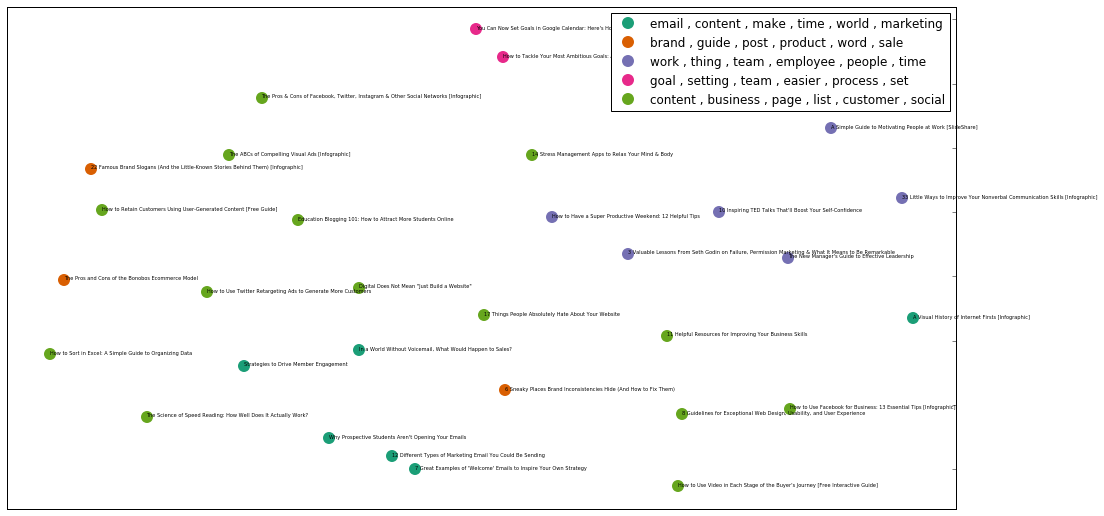

In [302]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=5)  

#uncomment the below to save the plot if need be
plt.savefig(input_file + 'clusters_small_noaxes.png', dpi=200)  
    
plt.show() #show the plot



In [303]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [304]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
# html = mpld3.fig_to_html(fig)
# print(html)

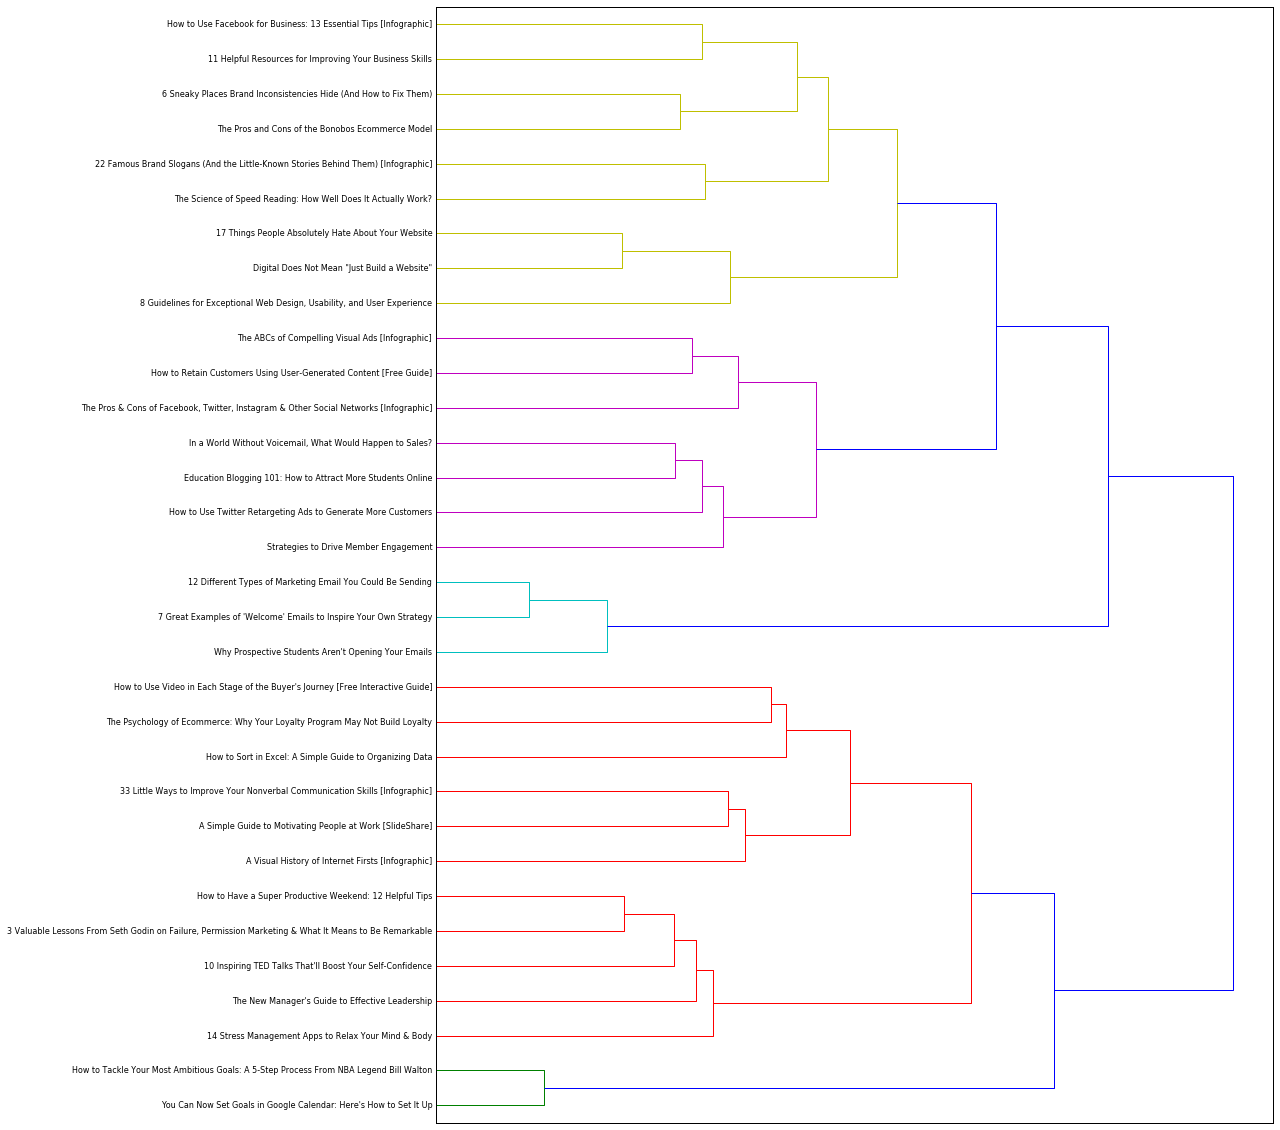

In [305]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=titles.values.tolist());

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

# plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig( input_file + 'ward_clusters.png', dpi=200) #save figure as ward_clusters